# Import dependencies

In [7]:
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import plotly.figure_factory as ff
from copy import deepcopy
from typing import List, Dict

In [2]:
df = pd.read_csv('problem_10m_100j.csv')
df = df.drop(columns=['Unnamed: 0'])
df.columns = [""] * len(df.columns)
df

,,,,,,,,,,
0,1,12,19,11,15,14,17,1,12,13
1,2,19,11,5,12,17,11,1,19,14
2,16,16,6,19,7,2,11,15,14,5
3,6,15,15,13,19,9,9,10,12,10
4,3,13,10,15,9,9,10,17,6,14
...,...,...,...,...,...,...,...,...,...,...
95,13,18,9,19,17,6,18,13,17,15
96,12,13,8,7,4,3,11,17,18,19
97,13,9,13,9,3,5,10,9,8,10
98,1,1,12,4,14,18,2,13,13,15


In [9]:
# Particle class
class Particle:
    def __init__(self, num_jobs, num_machines, processing_times):
        self.num_jobs = num_jobs
        self.num_machines = num_machines
        self.processing_times = processing_times

        # Initial position: Assign jobs to random machines
        self.position = [random.randint(0, num_machines - 1) for _ in range(num_jobs)]
        self.velocity = [0] * num_jobs

        # Initial fitness
        self.fitness = self.calculate_makespan(self.position)
        self.best_position = deepcopy(self.position)
        self.best_fitness = self.fitness

    def calculate_makespan(self, position):
        """Calculate the makespan based on the current job-machine assignment."""
        machine_times = [0] * self.num_machines
        for job, machine in enumerate(position):
            machine_times[machine] += self.processing_times[job][machine]
        return max(machine_times)

    def update(self, global_best_position, inertia, c1, c2):
        """Update position and velocity."""
        for i in range(self.num_jobs):
            r1 = random.random()
            r2 = random.random()

            # Update velocity
            self.velocity[i] = (inertia * self.velocity[i]
                + c1 * r1 * (self.best_position[i] - self.position[i])
                + c2 * r2 * (global_best_position[i] - self.position[i]))

            # Update position: random chance to change the job assignment based on velocity
            if random.random() < abs(self.velocity[i]):
                self.position[i] = random.randint(0, self.num_machines - 1)

        # Update fitness
        self.fitness = self.calculate_makespan(self.position)
        if self.fitness < self.best_fitness:
            self.best_fitness = self.fitness
            self.best_position = deepcopy(self.position)  # Store the best position

In [10]:
# PSO class
class PSO:
    def __init__(self, num_jobs, num_machines, processing_times, num_particles, num_iterations, inertia, c1, c2):
        self.num_jobs = num_jobs
        self.num_machines = num_machines
        self.processing_times = processing_times

        self.num_particles = num_particles
        self.num_iterations = num_iterations
        self.inertia = inertia
        self.c1 = c1
        self.c2 = c2

        # Initialize particles
        self.particles = [
            Particle(num_jobs, num_machines, processing_times)
            for _ in range(num_particles)
        ]
        self.global_best_particle = min(self.particles, key=lambda p: p.fitness)

    def optimize(self):
        """Run the optimization process."""
        no_improve_count = 0
        for iteration in range(self.num_iterations):
            for particle in self.particles:
                particle.update(self.global_best_particle.best_position, self.inertia, self.c1, self.c2)

            # Update global_best_particle each iteration
            best_particle = min(self.particles, key=lambda p: p.best_fitness)
            
            # Update only if fitness improves
            if best_particle.best_fitness < self.global_best_particle.best_fitness:
                self.global_best_particle.best_position = best_particle.best_position.copy() 
                self.global_best_particle.best_fitness = best_particle.best_fitness
                no_improve_count = 0
            else:
                no_improve_count += 1

            # Early stopping condition
            if no_improve_count >= 20:
                print(f"Early stopping at iteration {iteration + 1}")
                break

            # Log progress
            print(f"Iteration {iteration + 1}, Best Makespan: {self.global_best_particle.best_fitness}")

        return self.global_best_particle

    def plot_gantt_chart(self, processing_times, position, num_machines):
        """Visualize the schedule as a Gantt chart with total processing time and job count per machine."""
        machine_tasks = {i: [] for i in range(num_machines)}
        machine_end_times = [0] * num_machines
        machine_total_times = [0] * num_machines
        machine_job_counts = [0] * num_machines  # Job count per machine
        
        # Calculate start time, finish time, and job count
        for job, machine in enumerate(position):
            start_time = machine_end_times[machine]
            finish_time = start_time + processing_times[job][machine]
            machine_tasks[machine].append((f"Job {job+1}:{processing_times[job][machine]}", start_time, finish_time))
            machine_end_times[machine] = finish_time
            machine_total_times[machine] += processing_times[job][machine]
            machine_job_counts[machine] += 1
        
        colors = list(plt.cm.tab20.colors)
        fig, ax = plt.subplots(figsize=(30, 6))
        
        # Draw the job bars on the Gantt chart
        for machine, tasks in machine_tasks.items():
            for task, start, finish in tasks:
                ax.barh(machine, finish - start, left=start, 
                       color=colors[machine % len(colors)], edgecolor='black')
                ax.text((start + finish) / 2, machine, task, 
                       ha='center', va='center', color='white', fontsize=8)
        
        # Add total time and job count labels
        max_end_time = max(machine_end_times)
        for machine in range(num_machines):
            total_time = machine_total_times[machine]
            job_count = machine_job_counts[machine]
            info_text = f'Total time: {total_time} | Jobs: {job_count}'
            ax.text(max_end_time + 1, machine, 
                   info_text, 
                   va='center', ha='left', fontsize=10)
        
        ax.set_xlim(0, max_end_time + max_end_time * 0.2)  # Adjust space for labels
        ax.set_yticks(range(num_machines))
        ax.set_yticklabels([f"Machine {i+1}" for i in range(num_machines)])
        ax.set_xlabel("Time")
        ax.set_title("Gantt Chart")
        
        plt.savefig("gantt.png")
        plt.show()

Iteration 1, Best Makespan: 4
Iteration 2, Best Makespan: 4
Iteration 3, Best Makespan: 4
Iteration 4, Best Makespan: 4
Iteration 5, Best Makespan: 4
Iteration 6, Best Makespan: 4
Iteration 7, Best Makespan: 4
Iteration 8, Best Makespan: 4
Iteration 9, Best Makespan: 4
Iteration 10, Best Makespan: 4
Iteration 11, Best Makespan: 4
Iteration 12, Best Makespan: 4
Iteration 13, Best Makespan: 4
Iteration 14, Best Makespan: 4
Iteration 15, Best Makespan: 4
Iteration 16, Best Makespan: 4
Iteration 17, Best Makespan: 4
Iteration 18, Best Makespan: 4
Iteration 19, Best Makespan: 4
Early stopping at iteration 20
Best makespan: 4


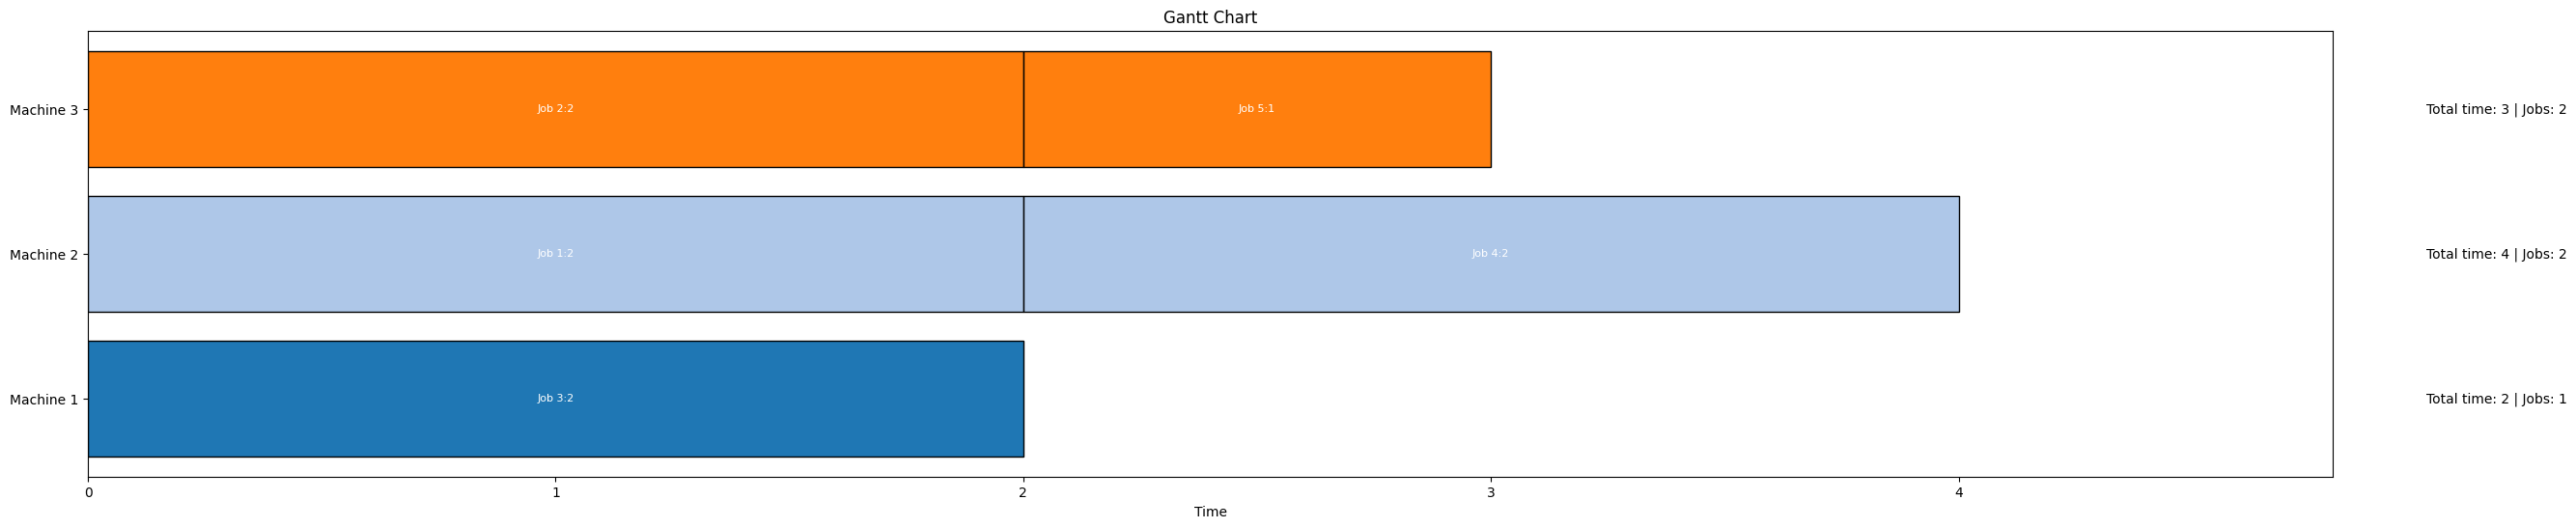

In [24]:
# Example of how to use the PSO class
df = [
        [3, 2, 5],  # Job 0 processing times
        [4, 3, 2],  # Job 1 processing times
        [2, 7, 3],  # Job 2 processing times
        [3, 2, 4],  # Job 3 processing times
        [6, 4, 1]   # Job 4 processing times
    ]
num_jobs = 5 # Number of jobs
num_machines = 3  # Number of machines

# Optimization parameters
num_particles = 60  # Number of particles
num_iterations = 200  # Number of iterations
inertia = 0.8  # Inertia weight
c1 = 1.5  # Local learning coefficient
c2 = 2.5  # Global learning coefficient

# Generate processing times (assume df is a DataFrame)
processing_times = df

# Create and run PSO
pso = PSO(num_jobs, num_machines, processing_times, 
          num_particles, num_iterations, 
          inertia, c1, c2)

# Optimize and get best particle
best_particle = pso.optimize()

# Print best makespan
print("Best makespan:", best_particle.best_fitness)

# Plot Gantt chart
pso.plot_gantt_chart(processing_times, best_particle.best_position, num_machines)